# Web Scraping, Minutes and Press Conference Transcript  and Speech

In [1]:
import requests
import os
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor, as_completed
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd

**requests:** This library is used to send HTTP requests to download the PDF files from the given URLs. It is a simple and user-friendly library that allows making GET or POST requests and handle responses, making it ideal for web scraping tasks like downloading files.

**os:** The os module in Python provides functions to interact with the operating system, such as creating directories, checking if files exist, and managing file paths. We use it here to manage the saving, deletion, and verification of files and folders.

**concurrent.futures:** The ThreadPoolExecutor from this module allows us to perform multithreading, which helps us speed up the process by handling multiple download and conversion tasks simultaneously. This is crucial for optimizing performance when working with large datasets, such as downloading and processing documents over several years.

**datetime and timedelta:** These modules are part of Python's standard library and are used to handle date-related operations. In our code, they are essential for generating the date strings for every day within each year, ensuring that all possible dates for FOMC meeting documents are tried.

**BeautifulSoup from bs4**: We use BeautifulSoup in this script to parse and navigate the HTML content of the web pages we scrape from the Federal Reserve's speeches website.

**urljoin from urllib.parse**: We use urljoin to combine the base URL of the speeches page with the relative URLs found in the HTML. Since many of the links on the website are relative, urljoin helps us form complete URLs that can be used to access individual speech pages or download PDF files.

#### Description:

**For FOMC minutes and press conference** the url is quite predicatble in format:   

minutes_url_template = 'https://www.federalreserve.gov/monetarypolicy/files/fomcminutes{}.pdf'
press_conf_url_template = 'https://www.federalreserve.gov/mediacenter/files/FOMCpresconf{}.pdf'
 
This allow us for systematic scraping 

**Unlike FOMC minutes and press conferences**, which typically follow a predictable URL structure (e.g., based on dates in the YYYYMMDD format), 
                                             
FOMC speeches may not always have such a predictable naming convention therefore, we use BeautifulSoup for speech downloads. 
                 
This allows us to scrape the webpage, extract links to the individual speeches, and **DIRECTLY SCRAPE THEM DOWN AS TXT (PDF OF SPEECH IS MESSY WITH FOOTNOTES THAT PERSISTENTLY CAUSE ISSUES)**. 

In [6]:
# Base URLs and templates for minutes and press conferences
minutes_url_template = 'https://www.federalreserve.gov/monetarypolicy/files/fomcminutes{}.pdf'
press_conf_url_template = 'https://www.federalreserve.gov/mediacenter/files/FOMCpresconf{}.pdf'

# Create folders to save the PDF files
output_dir_minutes_pressconf = r'E:\FOMC_Minutes_PressConferences_TXT'

if not os.path.exists(output_dir_speeches):
    os.makedirs(output_dir_speeches)

if not os.path.exists(output_dir_minutes_pressconf):
    os.makedirs(output_dir_minutes_pressconf)

def download_pdf(pdf_url, save_path):
    """
    Downloads a PDF from the specified URL and saves it to the given file path.

    Args:
        pdf_url (str): The URL from which to download the PDF.
        save_path (str): The file path (including filename) where the downloaded PDF should be saved.

    Returns:
        bool: True if the PDF was successfully downloaded, False otherwise.

    Example:
        pdf_url = "https://www.federalreserve.gov/mediacenter/files/speech20240131.pdf"
        save_path = r"E:\Fed_Speeches_TXT\speech20240131.pdf"
        download_pdf(pdf_url, save_path)
    """
    try:
        response = requests.get(pdf_url)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
            return True
        return False
    except Exception as e:
        return False

def download_by_date(date_str, file_type, save_folder):
    """
    Downloads PDFs for a specific date by constructing URLs for different types (e.g., FOMC minutes, press conferences).

    Args:
        date_str (str): The date string in 'YYYYMMDD' format, used to generate the URLs and file names.
        file_type (str): The type of file to download, such as 'minutes' or 'press_conf'.
        save_folder (str): The folder path where the PDF should be saved.

    Example:
        date_str = "20240131"
        file_type = "press_conf"
        save_folder = r'E:\FOMC_Minutes_PressConferences_TXT'
        download_by_date(date_str, file_type, save_folder)
        # This would download the FOMC press conference PDF for January 31, 2024.
    """
    if file_type == "minutes":
        pdf_url = minutes_url_template.format(date_str)
    elif file_type == "press_conf":
        pdf_url = press_conf_url_template.format(date_str)
    
    pdf_name = f"{file_type}_{date_str}.pdf"
    save_path = os.path.join(save_folder, pdf_name)

    download_pdf(pdf_url, save_path)

def try_dates_for_year(year, file_type, save_folder):
    """
    Attempts to download PDFs for every day of the specified year for a particular file type.

    Args:
        year (int): The year for which to attempt downloading.
        file_type (str): The type of file to download (e.g., 'minutes', 'press_conf').
        save_folder (str): The folder where the downloaded PDFs should be saved.

    Example:
        year = 2023
        file_type = 'minutes'
        try_dates_for_year(2023, file_type, save_folder)
        # This would try to download minutes PDFs for every possible date in 2023.
    """
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    delta = timedelta(days=1)

    dates_to_try = []
    current_date = start_date
    while current_date <= end_date:
        dates_to_try.append(current_date.strftime('%Y%m%d'))
        current_date += delta

    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(download_by_date, date_str, file_type, save_folder) for date_str in dates_to_try]
        for future in as_completed(futures):
            pass  # No logging for individual downloads

def scrape_all_data_from_2012_to_current():
    """
    Scrapes and downloads FOMC minutes, press conferences, and speeches for all possible years from 2012 to the current year.

    The speeches will be saved in the 'Fed_Speeches_TXT' folder, and the minutes and press conferences
    will be saved in the 'FOMC_Minutes_PressConferences_TXT' folder.

    Example:
        scrape_all_data_from_2012_to_current()
        # This will scrape and download all available FOMC PDFs from 2012 up to the current year.
    """
    current_year = datetime.now().year
    print(f"Scraping all FOMC data from 2012 to {current_year}...")

    for year in range(2012, current_year + 1):
        print(f"Processing year {year}...")
        
        # Download minutes for the year using URL-based approach
        try_dates_for_year(year, 'minutes', output_dir_minutes_pressconf)
        
        # Download press conferences for the year using URL-based approach
        try_dates_for_year(year, 'press_conf', output_dir_minutes_pressconf)

# Call this function to start scraping all data
scrape_all_data_from_2012_to_current()

Scraping all FOMC data from 2012 to 2024...
Processing year 2012...
Processing year 2013...
Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...
Processing year 2021...
Processing year 2022...
Processing year 2023...
Processing year 2024...


In [36]:
base_url = "https://www.federalreserve.gov/newsevents/speeches.htm"
output_dir =  r'E:\Fed_Speeches'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def save_text_to_file(text, filename):
    """
    Save the extracted text content to a file.

    Args:
        text (str): The speech text content.
        filename (str): The filename to save the text content.

    Example:
        save_text_to_file("Sample speech content", "speech_2024.txt")
    """
    output_path = os.path.join(output_dir, filename)
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(text)


def clean_text(text):
    """
    Clean the extracted text by removing extra whitespace, newlines, unnecessary spaces, and footnotes.

    Args:
        text (str): The raw text content to clean.

    Returns:
        str: The cleaned text.

    Example:
        raw_text = "<a href='url'><sup>1</sup></a> This is a   test.\n\nAnother line."
        clean_text(raw_text)
        # Output: "This is a test. Another line."
    """
    # Remove excessive newlines (more than 2) and leading/trailing spaces
    cleaned_text = re.sub(r'\n\s*\n+', '\n\n', text).strip()  # Ensure only single newlines between paragraphs
    # Remove extra spaces within lines
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Replace multiple spaces/tabs/newlines with a single space
    # Remove footnote references in <a><sup>number</sup></a> format
    cleaned_text = re.sub(r'<a.*?><sup>\d+</sup></a>', '', cleaned_text)  # Remove <a href...><sup>1</sup></a>
    return cleaned_text


def fetch_speech_links(year_url):
    """
    Fetch all individual speech links from a specific year's speech index page.

    Args:
        year_url (str): The URL of the specific year's speech index page.

    Example:
        year_url = 'https://www.federalreserve.gov/newsevents/speech/2024-speeches.htm'
        fetch_speech_links(year_url)
    """
    response = requests.get(year_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all <a> tags that point to individual speeches within the year
        speech_links = soup.find_all('a', href=True)
        for link in speech_links:
            href = link['href']
            if '/newsevents/speech/' in href and not href.endswith('-speeches.htm'):
                speech_url = urljoin(base_url, href)
                
                # Fetch the speech page to extract text content
                fetch_speech_text(speech_url)


def fetch_speech_text(speech_url):
    """
    Fetch the text content from an individual speech page and save it to a text file.

    Args:
        speech_url (str): The URL of the speech page where the text is located.

    Example:
        speech_url = 'https://www.federalreserve.gov/newsevents/speech/2024-speech.htm'
        fetch_speech_text(speech_url)
    """
    response = requests.get(speech_url)
    if response.status_code == 200:
        speech_soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract the speech text content
        speech_content_div = speech_soup.find('div', class_='col-xs-12 col-sm-8 col-md-8')
        if speech_content_div:
            # Find the <hr> tag and extract everything before it
            hr_tag = speech_content_div.find('hr', align='left', size='1', width='33%')
            if hr_tag:
                # Traverse the contents and stop before the <hr> tag
                speech_text = ''
                for elem in speech_content_div.contents:
                    if elem == hr_tag:
                        break
                    speech_text += str(elem)
            else:
                speech_text = speech_content_div.get_text(separator='\n').strip()

            # Clean up HTML tags from the resulting text
            clean_html_text = BeautifulSoup(speech_text, 'html.parser').get_text(separator='\n').strip()

            # Clean the text to remove extra whitespaces, newlines, spaces within lines, and footnote references
            final_clean_text = clean_text(clean_html_text)

            # Create a filename for the text file
            filename = f"{speech_url.split('/')[-1].replace('.htm', '')}.txt"
            save_text_to_file(final_clean_text, filename)


def download_speeches_by_year(year):
    """
    Fetch and download all speeches for a specific year by accessing the speech index page. 

    This function verifies the availability of speeches for a given year, fetches speech links,
    and processes the speech text where available.

    Args:
        year (int): The year for which to fetch and download speeches.

    Example:
        download_speeches_by_year(2024)
    """
    print(f"Fetching speech txt for {year} ...")
    response = requests.get(base_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the link to the specific year index page (e.g., 2024-speeches.htm)
        year_link = soup.find('a', href=f'/newsevents/speech/{year}-speeches.htm')
        if year_link:
            year_url = urljoin(base_url, year_link['href'])
            fetch_speech_links(year_url)
        else:
            print(f"No index page found for year {year}.")
    else:
        print(f"Failed to retrieve speeches for {year}, status code: {response.status_code}")


# Download speeches for 2012 to 2024
for year in range(2012, 2025):
    download_speeches_by_year(year)

Fetching speech txt for 2012 ...
Fetching speech txt for 2013 ...
Fetching speech txt for 2014 ...
Fetching speech txt for 2015 ...
Fetching speech txt for 2016 ...
Fetching speech txt for 2017 ...
Fetching speech txt for 2018 ...
Fetching speech txt for 2019 ...
Fetching speech txt for 2020 ...
Fetching speech txt for 2021 ...
Fetching speech txt for 2022 ...
Fetching speech txt for 2023 ...
Fetching speech txt for 2024 ...


#### PDF Conversion

Note that what we have here is PDF for minutes and conference only we will need to convert them to **text** for analysis. We use Tika from https://tika.apache.org/.  It is cleaner and avoids messy formatting and conversion problems when we convert PDFs 

In [3]:
import os
import tika
from tika import parser
import re
# Download NLTK for sentence tokenization
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26491\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
def extract_transcript_raw_text(input_folder, output_folder):
    """
    Extract text from PDF files in the specified input folder, clean the text, 
    and save the cleaned text to the output folder.

    Args:
        input_folder (str): Path to the folder containing PDF files.
        output_folder (str): Path to the folder where cleaned text files will be saved.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    # Initialize Tika virtual machine
    tika.initVM()

    # Iterate through PDF files in the input folder and extract text
    for file in os.listdir(input_folder):
        if file.endswith(".pdf"):  # Process only PDF files
            raw_text = extract_raw_text(file, input_folder)  # Extract text
            cleaned_text = clean_text(raw_text)  # Clean up unnecessary headers, footers, etc.
            raw_text_path = os.path.join(output_folder, file.replace(".pdf", ".txt"))

            # Save the cleaned text to the specified path
            with open(raw_text_path, "w", encoding="utf-8") as f:
                f.write(cleaned_text)

def extract_raw_text(file, folder_path):
    """
    Extract text from a PDF file.

    Args:
        file (str): The name of the PDF file.
        folder_path (str): Path to the folder containing the PDF file.

    Returns:
        str: The extracted raw text from the PDF.
    """
    pdf_path = os.path.join(folder_path, file)
    parsed = parser.from_file(pdf_path)
    raw_text = parsed.get('content', '')  # Return an empty string if no content is found
    return raw_text

def clean_text(text):
    """
    Use regular expressions to remove headers, footers, page numbers, and specific text formats.

    Args:
        text (str): The raw text extracted from a PDF file.

    Returns:
        str: The cleaned text after removing unnecessary parts.
    """
    # Match and remove headers like "Page X Federal Open Market Committee"
    text = re.sub(r'Page \d+\s+Federal Open Market Committee.*', '', text)

    # Match and remove footers like "Minutes of the Meeting of January 24–25, 2012 Page X________"
    text = re.sub(r'Minutes of the Meeting of .* Page \d+[_]*', '', text)

    # Remove extra lines and blank lines
    text = re.sub(r'[_]+', '', text)
    text = re.sub(r'\n\s*\n', '\n', text)  # Remove extra blank lines

    # New: Remove lines starting with a month and ending with "FINAL"
    text = re.sub(r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}.*FINAL', '', text)

    # New: Remove page numbers like "X of Y", e.g., "2 of 29"
    text = re.sub(r'\b\d+\s+of\s+\d+', '', text)

    # New: Remove page numbers with the word "Page", e.g., "Page 1 of 25"
    text = re.sub(r'Page\s+\d+\s+of\s+\d+', '', text)

    return text
    
#output goes
minutes_pressconf_folder = r'E:\FOMC_Minutes_PressConferences'

# Automatically create these folders if they don't exist
os.makedirs(minutes_pressconf_folder, exist_ok=True)
extract_transcript_raw_text(r'E:\FOMC_Minutes_PressConferences_TXT', minutes_pressconf_folder)

2024-10-11 16:55:23,227 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to C:\Users\26491\AppData\Local\Temp\tika-server.jar.
2024-10-11 16:55:25,190 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to C:\Users\26491\AppData\Local\Temp\tika-server.jar.md5.
2024-10-11 16:55:25,792 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


# Factor Similarity Analysis:

### Parsing, Cleaning, Pre Analysis

The Factor Similarity Method leverages advanced Natural Language Processing (NLP) techniques, particularly FinBERT, to quantify the similarity between Federal Reserve statements and predefined key phrases representing specific economic sentiments, such as "Interest rates will rise" or "Inflation will rise."

FinBERT is fine-tuned on financial texts, making it well-suited to analyze the nuanced language of economic documents. It works by converting each sentence from the documents into high-dimensional vectors, known as embeddings(word as vector), which capture the contextual meaning of the sentence.

These embeddings are compared to the embeddings of key sentences using cosine similarity, resulting in a score that reflects how closely the document’s language aligns with the key economic statements. This similarity score serves as a factor that can explain financial market movements, such as changes in asset prices or interest rates.

This will be the first method we will apply in this project

In [4]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch
import os
# Suppress Warning as it is very ugly 
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertModel.from_pretrained('yiyanghkust/finbert-tone')

D:\Users\26491\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#### Steps Overview

**Compare Sentence with Key Sentence via Cosine Similarities** 

**Report Average Cosine Similarities for Each Document**

**Make it as a score/factor for yield analysis**

Finbert is not necessary any word embedding is fine BUT **as it is trained on finacial text only** it is prefered

In [168]:
# Load Texts 

In [6]:
def load_text_files(directory):
    """
    Load all text files from a directory into a dictionary.

    Args:
        directory (str): The path to the directory containing the text files.

    Returns:
        dict: A dictionary where keys are file names and values are the file content.
    
    Example:
        >>> load_text_files('path/to/directory')
        {'file1.txt': 'This is the content of file 1', 'file2.txt': 'This is file 2'}
    """
    text_data = {}
    for file_name in os.listdir(directory):
        if file_name.endswith('.txt'):  # Only process text files
            with open(os.path.join(directory, file_name), 'r', encoding='utf-8') as f:
                text_data[file_name] = f.read()
    return text_data

# Path to txt directories 
minutes_pressconf_path = r'E:\FOMC_Minutes_PressConferences'
speeches_path = r'E:\Fed_Speeches'

# Load files from both directories
minutes_texts = load_text_files(minutes_pressconf_path)
speeches_texts = load_text_files(speeches_path)

Financial Data Can be Quite **Noisy** as it is stated in article Trillion Dollar Words: A New Financial Dataset, Task & Market Analysis. Including large propotions of **irrelevent** words may induce biases.

We thus deployed a **Dictionary Filter** and like the author will only include words in the **A1 and B1** section https://github.com/gtfintechlab/fomc-hawkish-dovish/blob/main/code_model/rule_based.py


It has also comes to our attention that for minutes_pressconference files **ap-
propriat styles persists**. These needs to be carefully handeled before process to next steps e

**ORIGINAL QUOTE***  "Any sentence that contained an instance of the words outlined in panel A1 or B1 in Table 1 would be kept, while anything else would be filtered out." 

It may still has irrelevant ones but by **keyword searching** efficiency will be improved

In [10]:
A1 = ["inflation expectation", "interest rate", "bank rate", "fund rate", "price", "economic activity", "inflation",
      "employment"]

B1 = ["unemployment", "growth", "exchange rate", "productivity", "deficit", "demand", "job market", "monetary policy"]

In [11]:
def contains_keywords(sentence, word_lists):
    """
    Check if the sentence contains any of the keywords from the specified word lists.
    
    Args:
        sentence (str): The sentence to check.
        word_lists (list): List of keyword lists to check within the sentence.
    
    Returns:
        bool: True if any of the keywords are found, False otherwise.

    Example:
        sentence = "The inflation rate has been increasing."
        word_lists = [A1, B1]
        contains_keywords(sentence, word_lists)
        # Returns: True, because "inflation" is in A1
    """
    sentence_lower = sentence.lower()
    for keywords in word_lists:
        for word in keywords:
            if word in sentence_lower:
                return True
    return False

def preprocess_sentence(sentence):
    """
    Preprocess an individual sentence by fixing hyphenated words, removing split words,
    filtering out unwanted patterns, and removing digits and punctuation. It also removes
    sentences that do not contain relevant keywords from the A1 and B1 lists.
    
    The steps involved:
    1. Convert sentence to lowercase.
    2. Fix hyphenated words that are split across lines (e.g., "unemploy- ment" -> "unemployment").
    3. Remove unwanted characters and digits.
    4. Remove excessive spaces and normalize whitespace.
    5. Check if the sentence contains any relevant keywords from the A1 and B1 lists.
    6. If a relevant keyword is found, remove any ending punctuation like ".!?" and return the cleaned sentence.
    7. If no relevant keyword is found, return an empty string.
    
    Args:
        sentence (str): The raw sentence to preprocess.
    
    Returns:
        str: The cleaned sentence or an empty string if the sentence does not contain relevant keywords.
    
    Examples:
        >>> A1 = ['economy', 'inflation']
        >>> B1 = ['unemployment', 'growth']

        >>> sentence = "The unemploy- ment rate is decreasing."
        >>> preprocess_sentence(sentence)
        'the unemployment rate is decreasing'
        # The word "unemployment" is found in the B1 list, so the sentence is returned with "unemploy- ment" fixed.

        >>> sentence = "The inflation rate is at 2%."
        >>> preprocess_sentence(sentence)
        'the inflation rate is at'
        # The word "inflation" is found in the A1 list, so the sentence is returned with digits removed.

        >>> sentence = "The sky is blue."
        >>> preprocess_sentence(sentence)
        ''
        # No relevant keywords from A1 or B1 are found, so an empty string is returned.

        >>> sentence = "The economy grew 3.5% last year!"
        >>> preprocess_sentence(sentence)
        'the economy grew last year'
        # The word "economy" from A1 is found, digits are removed, and punctuation is stripped.
    """
    # Convert sentence to lowercase for uniformity
    sentence = sentence.lower()

    # Fix hyphenated words split across lines (e.g., "Sys- tem" -> "System")
    sentence = re.sub(r'(\w+)\s*-\s*(\w+)', r'\1\2', sentence)

    # Remove digits and unwanted characters (keeping basic punctuation for sentences)
    sentence = re.sub(r'[^\w\s\.\!\?]', '', sentence)  # Removes anything not a word, space, or punctuation

    # Normalize excessive spaces
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    # Remove digits
    sentence = re.sub(r'\d+', '', sentence)

    # Check if the sentence contains any relevant keywords from A1 or B1
    if contains_keywords(sentence, [A1, B1]):
        # Finally, remove any punctuation marks at the end
        sentence = re.sub(r'[\.!?]+$', '', sentence).strip()
        return sentence
    else:
        return ""  # Return an empty string if the sentence doesn't contain relevant keywords

def preprocess_document(text):
    """
    Preprocess a whole document by first splitting it into sentences, then applying
    preprocessing to each sentence, and finally returning a list of cleaned sentences.
    
    Args:
        text (str): The raw document text to preprocess.
    
    Returns:
        list: A list of cleaned sentences.

    Example:
        text = "The inflation rate has increased. The weather is pleasant."
        preprocess_document(text)
        # Returns: ["the inflation rate has increased"] because only the first sentence contains relevant keywords
    """
    # Tokenize the document into sentences using NLTK
    sentences = nltk.sent_tokenize(text)

    # Preprocess each sentence and remove empty or unwanted sentences
    processed_sentences = [
        preprocess_sentence(sentence) for sentence in sentences
        if sentence.strip()
    ]

    # Return the cleaned sentences as a list, filtering out any empty sentences
    return [sentence for sentence in processed_sentences if sentence]


In [12]:
# Test Case  You can replace it with other files, we have test all three cases and no fatal issues have been discovered
with open('E:/Fed_Speeches/bowman20190328a.txt', 'r', encoding='utf-8') as file:
    raw_text = file.read()

# Process the document
cleaned_sentences = preprocess_document(raw_text)

In [13]:
for c in cleaned_sentences:
    print(c)

the federal reserves monetary policy mandate is twofold to promote maximum employment and stable prices
we track commodity prices ag credit and exports as factors that influence our outlook on inflation and economic growth
the price of major agricultural commodities has also remained low in early
for example today the price of corn is about  percent lower than it was from  to
dairy producing states like new mexico are well aware that average milk prices were about  percent lower in  than from  to  and well below the highs of
the demand for chili peppers and pecans grown in new mexico is a good example of the kinds of regional variations we see in agriculture and many other industries
high interest rates in the early s in response to the great inflation contributed to the stress
during that time spurred by rising demand in china and a boom in biofuels farmers invested heavily in new equipment and technology to meet this rising demand
with current inflation low and stable interest rates 

In [14]:
len(cleaned_sentences)

15

In [15]:
def preprocess_document_dict(texts_dict):
    """
    Preprocess the content of each file in the dictionary.

    Args:
        texts_dict (dict): A dictionary with file names as keys and file contents as values.

    Returns:
        dict: A new dictionary where keys are file names and values are the preprocessed content.
    """
    return {file_name: preprocess_document(content) for file_name, content in texts_dict.items()}

# Preprocess texts
cleaned_minutes_texts = preprocess_document_dict(minutes_texts)
cleaned_speeches_texts = preprocess_document_dict(speeches_texts)

One important point to note is that **embedding DOES NOT HANDLE NUMBERS WELL** When we remove numbers during preprocessing, there are many invalid patterns that also need to be cleaned up

In [17]:
def remove_invalid_punctuation_sentences(text_dict):
    """
    Removes sentences where the majority of elements are repeated punctuation patterns like '. . .'
    and keeps sentences where more than 50% of the content consists of valid words (non-punctuation).
    
    Args:
        text_dict (dict): A dictionary with file names as keys and lists of sentences as values.
    
    Returns:
        dict: A filtered dictionary with invalid sentences removed.
    
    Example:
        >>> text_dict = {
        ...     'file1.txt': ['. . . unemployment rate', 'The inflation rate is increasing', '. . . . .'],
        ...     'file2.txt': ['PCE inflation is steady.', 'The unemployment rate dropped by 2%.', '. to . . to . Interest Rate']
        ... }
        >>> cleaned_dict = remove_invalid_punctuation_sentences(text_dict)
        >>> print(cleaned_dict)
        {
            'file1.txt': ['The inflation rate is increasing'],
            'file2.txt': ['PCE inflation is steady.', 'The unemployment rate dropped by 2%.']
        }
        
        In this example:
        - '. . . unemployment rate' is removed because the majority of the sentence is just repeated punctuation.
        - 'The inflation rate is increasing' is kept because it is a valid sentence with actual content.
        - '. to . . to .' is removed because it consists mainly of punctuation.
    
    Explanation:
        1. The sentence is split into individual words and punctuation elements.
        2. We count meaningful words (non-punctuation, actual words).
        3. If more than 50% of the sentence consists of valid words, it is kept.
        4. Otherwise, the sentence is discarded.

    """
    cleaned_dict = {}
    
    for file_name, sentences in text_dict.items():
        valid_sentences = []
        for sentence in sentences:
            # Split the sentence into words or punctuation sequences
            elements = sentence.split()
            
            # Count meaningful words (non-punctuation)
            meaningful_words = [word for word in elements if re.match(r'\w+', word)]
            
            # Calculate the proportion of meaningful words
            if len(meaningful_words) / len(elements) > 0.5:  # If more than 50% are valid words
                valid_sentences.append(sentence.strip())
        
        # Only add back the cleaned list of sentences if it's not empty
        if valid_sentences:
            cleaned_dict[file_name] = valid_sentences
    
    return cleaned_dict

# Example usage:
cleaned_minutes_texts1 = remove_invalid_punctuation_sentences(cleaned_minutes_texts)
cleaned_speeches_texts1 = remove_invalid_punctuation_sentences(cleaned_speeches_texts)

In [18]:
len(cleaned_minutes_texts1['minutes_20120125.txt'])

228

In [19]:
cleaned_speeches_texts1['barr20220907a.txt']

['a merged institution may be able to provide more competitive products and services but it could also have the potential to reduce competition and access to financial services in a geographic area by raising prices narrowing the range of services offered and reducing the supply of small business or community development loans that rely on local knowledge',
 'as we have seen with the growth of crypto assets in a rapidly rising and volatile market participants may come to believe that they understand new products only to learn that they dont and then suffer significant losses']

### Computing, Finbert Embedding Cosine Similarity, Day report of Hawkish and Dovish 

In [22]:
# Finbert Logics

The process starts by converting the input sentences (which are just strings of text) into tokens that the FinBERT model can understand. Input Sentence: "Interest rates are expected to rise." Tokenized Version: ["[CLS]", "Interest", "rates", "are", "expected", "to", "rise", "[SEP]"]

Then each tokenized sentence needs to fit within a maximum token length (512 tokens for BERT models). If a sentence is longer than this, it is truncated. If it’s shorter than the maximum length, it is padded with special padding tokens to ensure that all sentences in a batch have the same length. This makes it easier to process multiple sentences simultaneously.

Using **attention mechanism**, the tokens are processed through **multiple layers**

The CLS token is extracted at last as it now incorporates contextual information from all tokens in the sentence.

In [24]:
# Before we start 

BERT-like models have a hard limit of 512 tokens for any input sequence, so truncation is necessary when this limit is exceeded. It is a good practice to check whether such long sentences exist in our dictionary and evaluate whether they contain significant information. If important content is located in the truncated portion, we may need to apply alternative strategies, such as chunking or splitting, to preserve the meaning without losing crucial details.

In [26]:
def find_long_sentences(text_dict, max_length=512):
    """
    Find sentences in the text dictionary that exceed the specified token length.
    
    Args:
        text_dict (dict): A dictionary where keys are file names and values are lists of sentences.
        max_length (int): Maximum token length allowed (512 by default for BERT models).
    
    Returns:
        dict: A dictionary of file names and sentences that exceed the max token length.
    """
    long_sentences = {}

    for file_name, sentences in text_dict.items():
        for sentence in sentences:
            tokens = tokenizer(sentence, truncation=False)['input_ids']  # Tokenize without truncation
            if len(tokens) > max_length:
                if file_name not in long_sentences:
                    long_sentences[file_name] = []
                long_sentences[file_name].append({
                    'sentence': sentence,
                    'token_count': len(tokens)
                })
    
    return long_sentences

# Find long sentences in both cleaned_minutes_texts1 and cleaned_speeches_texts1
long_sentences_minutes = find_long_sentences(cleaned_minutes_texts1)
long_sentences_speeches = find_long_sentences(cleaned_speeches_texts1)

long_sentences_combined = {**long_sentences_minutes, **long_sentences_speeches}

# Print results
for file_name, long_sents in long_sentences_combined.items():
    print(f"\nFile: {file_name}")
    for sent_info in long_sents:
        print(f"- Sentence (truncated): {sent_info['sentence'][:100]}...")  # Print first 100 chars for inspection
        print(f"  Token count: {sent_info['token_count']}")


File: minutes_20120425.txt
- Sentence (truncated): present ben bernanke chairman william c. dudley vice chairman elizabeth duke jeffrey m. lacker denni...
  Token count: 571

File: minutes_20120801.txt
- Sentence (truncated): present ben bernanke chairman william c. dudley vice chairman elizabeth duke jeffrey m. lacker denni...
  Token count: 593

File: minutes_20121023.txt
- Sentence (truncated): present ben bernanke chairman william c. dudley vice chairman elizabeth duke jeffrey m. lacker denni...
  Token count: 599

File: minutes_20130619.txt
- Sentence (truncated): present ben bernanke chairman william c. dudley vice chairman james bullard elizabeth duke charles l...
  Token count: 698

File: minutes_20181108.txt
- Sentence (truncated): lorie k. logan deputy manager system open market account ann e. misback secretary office of the secr...
  Token count: 523

File: minutes_20181219.txt
- Sentence (truncated): lorie k. logan deputy manager system open market account ann e. misback s

It seems obvious that there are no **significant meanings** in these words, they might be truncated or even removed 

In [28]:
# Get Embeddings for All 

In [43]:
def get_sentence_embeddings(sentences, max_length=512, batch_size=8):
    """
    Get the embeddings of a list of sentences using FinBERT, with truncation applied for long sentences.
    
    The function takes a list of sentences, tokenizes them using the FinBERT tokenizer, and processes them 
    in batches. Each sentence is truncated if it exceeds the maximum sequence length (512 tokens), and padding
    is applied where necessary to ensure consistent input lengths. The model returns the embeddings for the 
    [CLS] token of each sentence, which serves as a representation of the entire sentence.

    Args:
        sentences (list): A list of sentences (strings) to be encoded.
        max_length (int, optional): Maximum number of tokens allowed in a sentence. Sentences longer than this
                                    will be truncated. The default value is 512, which is the maximum for BERT models.
        batch_size (int, optional): Number of sentences to process in each batch. Larger batch sizes are more
                                    memory efficient but may require more computational resources. Default is 8.

    Returns:
        torch.Tensor: A tensor containing the [CLS] token embeddings of the sentences. Each sentence is 
                      represented by a 768-dimensional vector (for BERT-based models like FinBERT).
    
    Example:
        >>> sentences = ["Interest rates are expected to rise.", "Inflation is projected to remain stable."]
        >>> embeddings = get_sentence_embeddings(sentences)
        >>> print(embeddings.shape)
        torch.Size([2, 768])  # Two sentences, each represented by a 768-dimensional vector

    Example with truncation:
        >>> long_sentence = "The economy is showing signs of recovery, but there are still challenges ahead, with some sectors " \
                            "facing significant hurdles as they attempt to recover from the impact of the global pandemic. " \
                            "It is critical that policymakers continue to focus on long-term strategies to foster growth and " \
                            "ensure stability in the financial markets. While the immediate focus has been on short-term economic " \
                            "stimulus measures, the long-term outlook requires structural reforms in several key sectors."
        >>> embeddings = get_sentence_embeddings([long_sentence])
        >>> print(embeddings.shape)
        torch.Size([1, 768])  # The sentence is truncated to 512 tokens and returns a single 768-dimensional embedding.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU if available
        with torch.no_grad():  # Disable gradient computation for inference
            outputs = model(**inputs)
        # Extract the [CLS] token embeddings for each sentence in the batch
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu()  # Move embeddings back to CPU after processing
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings, dim=0)  # Concatenate all batch embeddings into a single tensor

In [30]:
def extract_file_info(file_name):
    """
    Extract the date and file type from the file name.
    
    Args:
        file_name (str): The file name.
        
    Returns:
        tuple: Extracted date and file type.
    """
    date_match = re.search(r'\d{8}', file_name)
    if date_match:
        date = date_match.group(0)
    
    if 'press_conf' in file_name:
        file_type = 'press_conference'
    elif 'minutes' in file_name:
        file_type = 'minutes'
    else:
        file_type = 'speeches'
    
    return date, file_type

In [31]:
def compute_similarity(sentence_embeddings, key_sentence_embeddings):
    """
    Compute the cosine similarity between the document sentences and two key sentences (hawkish and dovish).
    
    Args:
        sentence_embeddings (torch.Tensor): Tensor of sentence embeddings (2D), shape: [n_sentences, embedding_size].
        key_sentence_embeddings (torch.Tensor): Tensor of key sentence embeddings (2D), shape: [2, embedding_size] 
                                                 where the first embedding is the hawkish key sentence and 
                                                 the second is the dovish key sentence.
    
    Returns:
        tuple: A tuple containing two float values:
               - The average cosine similarity with the hawkish sentence.
               - The average cosine similarity with the dovish sentence.
    
    Example:
        >>> from sklearn.metrics.pairwise import cosine_similarity
        >>> import torch

        >>> # Example sentence embeddings for a document with 3 sentences (768-dimensional embeddings)
        >>> sentence_embeddings = torch.tensor([[0.1, 0.2, 0.3, ..., 0.7],  # Example embeddings
                                                 [0.4, 0.3, 0.2, ..., 0.6],
                                                 [0.5, 0.2, 0.8, ..., 0.7]])

        >>> # Example key sentence embeddings for hawkish and dovish sentences
        >>> key_sentence_embeddings = torch.tensor([[0.3, 0.4, 0.5, ..., 0.8],  # Hawkish embedding
                                                     [0.6, 0.3, 0.2, ..., 0.5]])  # Dovish embedding

        >>> # Compute the cosine similarity between document sentences and both key sentences
        >>> avg_hawkish_similarity, avg_dovish_similarity = compute_similarity(sentence_embeddings, key_sentence_embeddings)

        >>> print(f"Average Hawkish Similarity: {avg_hawkish_similarity}")
        >>> print(f"Average Dovish Similarity: {avg_dovish_similarity}")
    """
    hawkish_embedding = key_sentence_embeddings[0].unsqueeze(0)  # [1, embedding_size]
    dovish_embedding = key_sentence_embeddings[1].unsqueeze(0)   # [1, embedding_size]
    
    # Compute cosine similarity with the hawkish key sentence
    hawkish_similarities = cosine_similarity(sentence_embeddings.numpy(), hawkish_embedding.numpy())
    avg_hawkish_similarity = hawkish_similarities.mean()  # Average similarity with hawkish sentence
    
    # Compute cosine similarity with the dovish key sentence
    dovish_similarities = cosine_similarity(sentence_embeddings.numpy(), dovish_embedding.numpy())
    avg_dovish_similarity = dovish_similarities.mean()  # Average similarity with dovish sentence
    
    return avg_hawkish_similarity, avg_dovish_similarity

In [32]:
def create_combined_dataframe(text_dict, hawkish_sentence, dovish_sentence):
    """
    Create three separate DataFrames for each file type (press conferences, minutes, speeches),
    along with separate similarity scores for hawkish and dovish key sentences. The hawkish sentence typically
    implies a monetary policy stance focused on tightening or raising interest rates to control inflation. 
    The dovish sentence typically implies a monetary policy stance focused on stimulating economic growth or 
    maintaining low interest rates.

    Args:
        text_dict (dict): Dictionary where keys are file names and values are lists of sentences.
        hawkish_sentence (str): The key sentence representing hawkish sentiment (e.g., 'Interest rates will rise').
        dovish_sentence (str): The key sentence representing dovish sentiment (e.g., 'Interest rates will remain low').
    
    Returns:
        tuple: A tuple containing three DataFrames (one for each file type):
               - press_conferences_df
               - minutes_df
               - speeches_df
    
    Example:
        >>> cleaned_minutes_texts1 = {
                "file1_minutes.txt": ["Interest rates are expected to rise.", "The market is stable."],
            }
        >>> cleaned_speeches_texts1 = {
                "file2_speeches.txt": ["Unemployment rates are falling.", "We expect strong growth next year."]
            }
        >>> combined_texts = {**cleaned_minutes_texts1, **cleaned_speeches_texts1}
        >>> hawkish_sentence = "Interest rates will rise"
        >>> dovish_sentence = "Interest rates will remain low"
        >>> press_conferences_df, minutes_df, speeches_df = create_combined_dataframe(combined_texts, hawkish_sentence, dovish_sentence)
        >>> print(press_conferences_df)
        >>> print(minutes_df)
        >>> print(speeches_df)
    """
    # Get embeddings for the hawkish and dovish key sentences
    key_sentence_embeddings = get_sentence_embeddings([hawkish_sentence, dovish_sentence])  # [2, 768]
    
    press_conferences_data = []
    minutes_data = []
    speeches_data = []
    
    for file_name, sentences in text_dict.items():
        # Extract the date and file type from the file name
        date, file_type = extract_file_info(file_name)
        
        # Get embeddings for the document's sentences
        sentence_embeddings = get_sentence_embeddings(sentences)
        
        # Compute cosine similarities with both hawkish and dovish key sentences
        avg_hawkish_similarity, avg_dovish_similarity = compute_similarity(sentence_embeddings, key_sentence_embeddings)
        
        # Prepare the data dictionary with the similarity scores
        data_row = {
            'file_name': file_name,
            'date': date,
            'hawkish_similarity': avg_hawkish_similarity,
            'dovish_similarity': avg_dovish_similarity
        }
        
        # Add to the respective list based on the file type
        if file_type == 'press_conference':
            press_conferences_data.append(data_row)
        elif file_type == 'minutes':
            minutes_data.append(data_row)
        elif file_type == 'speeches':
            speeches_data.append(data_row)
    
    # Convert each list of data into its own DataFrame
    press_conferences_df = pd.DataFrame(press_conferences_data)
    minutes_df = pd.DataFrame(minutes_data)
    speeches_df = pd.DataFrame(speeches_data)
    
    return press_conferences_df, minutes_df, speeches_df

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Combined dictionaries
combined_texts = {**cleaned_minutes_texts1, **cleaned_speeches_texts1}

# Hawkish and Dovish sentences for comparison
hawkish_sentence = "To prevent rising inflation the central bank will raise interest rates to maintain price stability"
dovish_sentence = " Inflation is expected to rise but the central bank will maintain low interest rates to support economic growth"

# Create the combined DataFrames for each file type
press_conferences_df, minutes_df, speeches_df = create_combined_dataframe(combined_texts, hawkish_sentence, dovish_sentence)

# Print the DataFrames
print("Press Conferences DataFrame")
print(press_conferences_df)

print("\nMinutes DataFrame")
print(minutes_df)

print("\nSpeeches DataFrame")
print(speeches_df)

D:\Users\26491\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Press Conferences DataFrame
                  file_name      date  hawkish_similarity  dovish_similarity
0   press_conf_20120125.txt  20120125            0.575890           0.588465
1   press_conf_20120425.txt  20120425            0.559729           0.582176
2   press_conf_20120620.txt  20120620            0.541132           0.569482
3   press_conf_20120913.txt  20120913            0.551295           0.575099
4   press_conf_20121212.txt  20121212            0.564311           0.582459
..                      ...       ...                 ...                ...
71  press_conf_20240320.txt  20240320            0.543657           0.572944
72  press_conf_20240501.txt  20240501            0.540817           0.561541
73  press_conf_20240612.txt  20240612            0.537977           0.556303
74  press_conf_20240731.txt  20240731            0.544226           0.561080
75  press_conf_20240918.txt  20240918            0.544030           0.564937

[76 rows x 4 columns]

Minutes DataFrame
      

In [46]:
def average_across_all_types(press_df, minutes_df, speeches_df):
    """
    Concatenate the press conferences, minutes, and speeches DataFrames, then compute the average 
    'hawkish_similarity' and 'dovish_similarity' scores for each date across all document types.

    Args:
        press_df (pd.DataFrame): DataFrame for press conferences.
        minutes_df (pd.DataFrame): DataFrame for minutes.
        speeches_df (pd.DataFrame): DataFrame for speeches.

    Returns:
        pd.DataFrame: A DataFrame with 'date' as the index and the average similarity scores across 
                      all document types.
    """
    # Concatenate the DataFrames
    combined_df = pd.concat([press_df, minutes_df, speeches_df], ignore_index=True)
    
    # Group by date and compute the average hawkish and dovish similarity scores
    averaged_df = combined_df.groupby('date').agg({
        'hawkish_similarity': 'mean',
        'dovish_similarity': 'mean'
    }).reset_index()

    # Set 'date' as the index
    averaged_df.set_index('date', inplace=True)

    return averaged_df

averaged_scores_df = average_across_all_types(press_conferences_df, minutes_df, speeches_df)
# Print the final DataFrame
print("Averaged Similarity Scores Across All Document Types by Date")
print(averaged_scores_df)

Averaged Similarity Scores Across All Document Types by Date
          hawkish_similarity  dovish_similarity
date                                           
20110210            0.493262           0.547488
20120106            0.516190           0.555285
20120107            0.501264           0.569589
20120113            0.532391           0.556770
20120116            0.623997           0.608053
...                      ...                ...
20241002            0.565029           0.586119
20241008            0.575422           0.574265
20241009            0.590807           0.586511
20241010            0.527189           0.559260
20241011            0.531158           0.523284

[716 rows x 2 columns]


### Regression Analysis, Intepretation & Conclusion For Method One

First Let's analyze 2yr-10yr spread, when hawkish happens it is usually the case that the **spread narrows** (flattening, may
invert) and when dovish it **widdens.** We load the provided data and start from there

There seems to be missing values of change but they are **easy to compute** 

In [50]:
spread = pd.read_excel('210spread.xlsx')
# Convert 'Date' to datetime
spread['Date'] = pd.to_datetime(spread['Date'])
# Set 'Date' as the index and sort in descending order
spread.set_index('Date', inplace=True)
spread.sort_index(ascending=True, inplace=True)
# Check the first few rows
print(spread.head())

             PX_LAST  Change  % Change
Date                                  
2011-12-30  163.5993     NaN       NaN
2012-01-02  163.5993     NaN       NaN
2012-01-03  169.1294     NaN       NaN
2012-01-04  171.6850     NaN       NaN
2012-01-05  173.4169     NaN       NaN


In [51]:
# I print for verification

In [52]:
print(spread.tail())

            PX_LAST  Change   % Change
Date                                  
2024-09-30  13.9761 -5.2502 -27.307386
2024-10-01  12.6119 -1.3642  -9.760949
2024-10-02  13.9342  1.3223  10.484542
2024-10-03  14.0354  0.1012   0.726271
2024-10-04   4.4360 -9.5994 -68.394203


In [53]:
# I compute 

In [54]:
spread['Change'] = spread['PX_LAST'].diff()
spread['% Change'] = spread['PX_LAST'].pct_change() * 100
# we would like to see intraday reaction
spread['next_change'] = spread['Change'].shift(-1)

In [55]:
spread.tail()

,PX_LAST,Change,% Change,next_change
Date,,,,
2024-09-30,13.9761,-5.2502,-27.307386,-1.3642
2024-10-01,12.6119,-1.3642,-9.760949,1.3223
2024-10-02,13.9342,1.3223,10.484542,0.1012
2024-10-03,14.0354,0.1012,0.726271,-9.5994
2024-10-04,4.4360,-9.5994,-68.394203,NaN


In [56]:
spread.head()

,PX_LAST,Change,% Change,next_change
Date,,,,
2011-12-30,163.5993,NaN,NaN,0.0000
2012-01-02,163.5993,0.0000,0.000000,5.5301
2012-01-03,169.1294,5.5301,3.380271,2.5556
2012-01-04,171.6850,2.5556,1.511032,1.7319
2012-01-05,173.4169,1.7319,1.008766,-3.3382


In [57]:
averaged_scores_df

,hawkish_similarity,dovish_similarity
date,,
20110210,0.493262,0.547488
20120106,0.516190,0.555285
20120107,0.501264,0.569589
20120113,0.532391,0.556770
20120116,0.623997,0.608053
...,...,...
20241002,0.565029,0.586119
20241008,0.575422,0.574265
20241009,0.590807,0.586511


In [88]:
# the format in averaged_scores_df is 'YYYYMMDD', let's standardize both to 'YYYY-MM-DD'
averaged_scores_df.index = pd.to_datetime(averaged_scores_df.index, format='%Y%m%d', errors='coerce')
spread.index = pd.to_datetime(spread.index, errors='coerce')  # Standard ISO format for 'YYYY-MM-DD'
# Now, merge 
regress = averaged_scores_df.copy()
regress = pd.merge(regress, spread[['next_change']], left_index=True, right_index=True, how='inner')
print(regress.head())

            hawkish_similarity  dovish_similarity  next_change
2012-01-06            0.516190           0.555285       1.1750
2012-01-13            0.532391           0.556770       0.0000
2012-01-16            0.623997           0.608053      -0.3094
2012-01-25            0.564804           0.585845      -5.1518
2012-02-16            0.529457           0.540048       1.8807


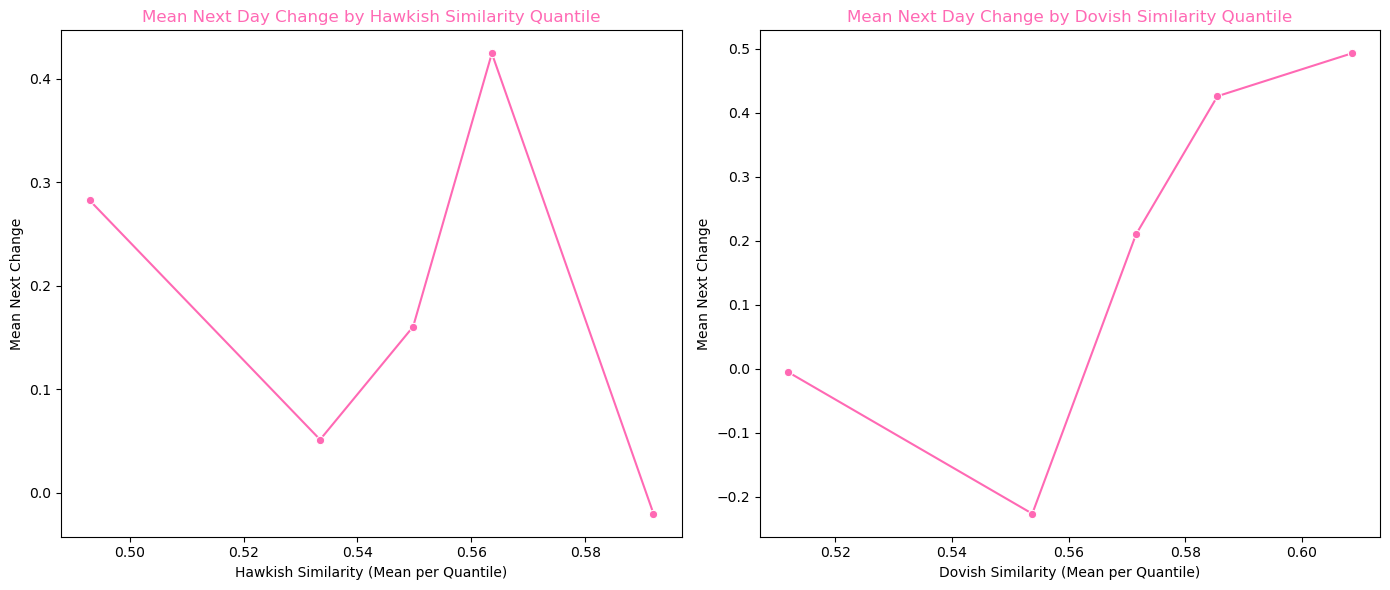

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Replace infinite values with NaN in the 'regress' DataFrame
regress.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define the number of quantiles
n_quantiles = 5

# Create quantile bins for hawkish and dovish similarity
regress['hawkish_quantile'] = pd.qcut(regress['hawkish_similarity'], q=n_quantiles, labels=False)
regress['dovish_quantile'] = pd.qcut(regress['dovish_similarity'], q=n_quantiles, labels=False)

# Group by the quantile and calculate the mean 'next_change' for each quantile
hawkish_grouped = regress.groupby('hawkish_quantile').agg({'next_change': 'mean', 'hawkish_similarity': 'mean'})
dovish_grouped = regress.groupby('dovish_quantile').agg({'next_change': 'mean', 'dovish_similarity': 'mean'})

# Create the figure for the FacetGrid with custom colors
plt.figure(figsize=(14, 6))

# Plot 1: Hawkish quantile vs mean 'next_change' with a pink theme
plt.subplot(1, 2, 1)
sns.lineplot(x=hawkish_grouped['hawkish_similarity'], y=hawkish_grouped['next_change'], color='#FF69B4', marker='o')
plt.title('Mean Next Day Change by Hawkish Similarity Quantile', color='#FF69B4')
plt.xlabel('Hawkish Similarity (Mean per Quantile)')
plt.ylabel('Mean Next Change')

# Plot 2: Dovish quantile vs mean 'next_change' with a pink theme
plt.subplot(1, 2, 2)
sns.lineplot(x=dovish_grouped['dovish_similarity'], y=dovish_grouped['next_change'], color='#FF69B4', marker='o')
plt.title('Mean Next Day Change by Dovish Similarity Quantile', color='#FF69B4')
plt.xlabel('Dovish Similarity (Mean per Quantile)')
plt.ylabel('Mean Next Change')

# Style and show the plot
plt.tight_layout()
plt.show()

In [98]:
import statsmodels.api as sm
X = regress[['dovish_similarity', 'hawkish_similarity']]
y = regress['next_change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            next_change   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.132
Date:                Sat, 12 Oct 2024   Prob (F-statistic):             0.0443
Time:                        00:24:25   Log-Likelihood:                -1848.3
No. Observations:                 683   AIC:                             3703.
Df Residuals:                     680   BIC:                             3716.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.5094      2

Based on the 02-10 year spread it seems that **factor similariy method** yield statistic significant result when explaning  **next day's spread divergence and convergence**. The R-squared seems very low which may have indicated lack of linaear relationship or there lacks **control variables** to explain variances of the spread patterns

**Lets take a closer look at other datas, the GT2**  For GT2 lets see whether intra day happens significantly (different methodology)

In [143]:
short = pd.read_excel('GT2.xlsx')
short['Date'] = pd.to_datetime(short['Date'])
# Set 'Date' as the index and sort in descending order
short.set_index('Date', inplace=True)
short.sort_index(ascending=True, inplace=True)
# Check the first few rows
short['Change'] = short['PX_MID'].diff()

In [145]:
short

,PX_MID,Change,% Change
Date,,,
2011-12-30,0.241,NaN,NaN
2012-01-02,0.241,0.000,NaN
2012-01-03,0.257,0.016,NaN
2012-01-04,0.261,0.004,NaN
2012-01-05,0.261,0.000,NaN
...,...,...,...
2024-09-30,3.642,0.082,2.303371
2024-10-01,3.606,-0.036,-0.988468
2024-10-02,3.643,0.037,1.026068


In [147]:
regress = averaged_scores_df.copy()
regress = pd.merge(regress, short[['Change']], left_index=True, right_index=True, how='inner')
print(regress.head())

            hawkish_similarity  dovish_similarity  Change
2012-01-06            0.516190           0.555285  -0.003
2012-01-13            0.532391           0.556770  -0.008
2012-01-16            0.623997           0.608053   0.000
2012-01-25            0.564804           0.585845  -0.012
2012-02-16            0.529457           0.540048   0.028


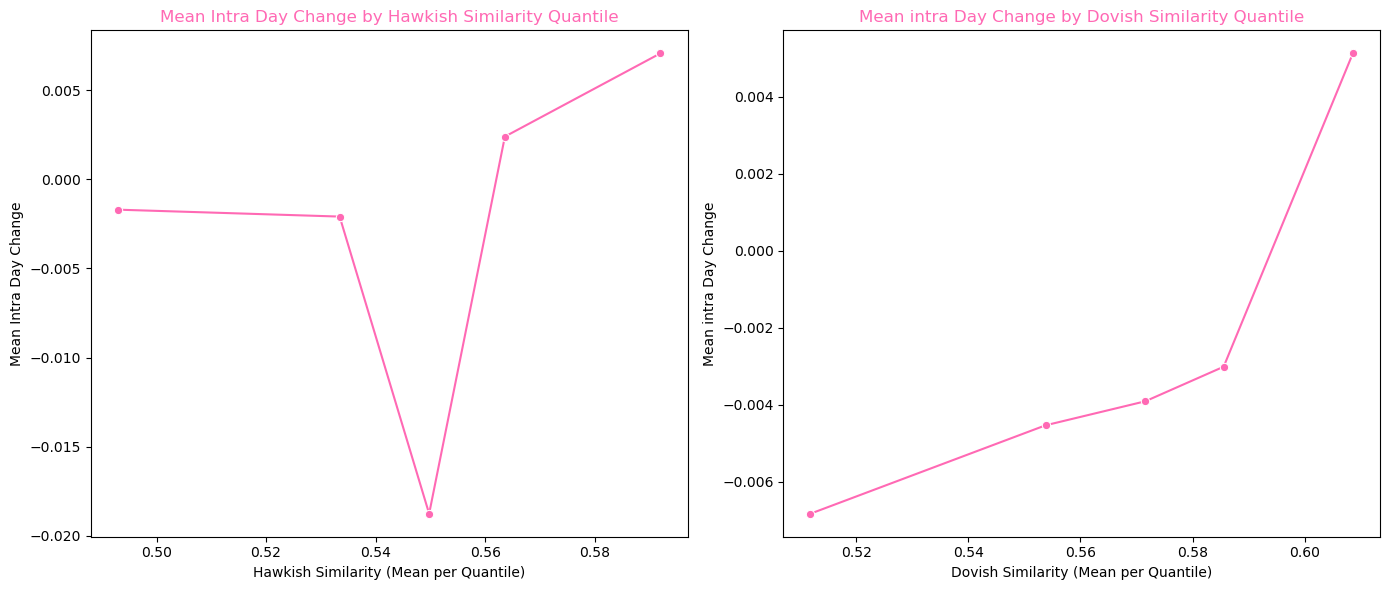

In [149]:
# Replace infinite values with NaN in the 'regress' DataFrame
regress.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define the number of quantiles
n_quantiles = 5

# Create quantile bins for hawkish and dovish similarity
regress['hawkish_quantile'] = pd.qcut(regress['hawkish_similarity'], q=n_quantiles, labels=False)
regress['dovish_quantile'] = pd.qcut(regress['dovish_similarity'], q=n_quantiles, labels=False)

# Group by the quantile and calculate the mean 'next_change' for each quantile
hawkish_grouped = regress.groupby('hawkish_quantile').agg({'Change': 'mean', 'hawkish_similarity': 'mean'})
dovish_grouped = regress.groupby('dovish_quantile').agg({'Change': 'mean', 'dovish_similarity': 'mean'})

# Create the figure for the FacetGrid with custom colors
plt.figure(figsize=(14, 6))

# Plot 1: Hawkish quantile vs mean 'next_change' with a pink theme
plt.subplot(1, 2, 1)
sns.lineplot(x=hawkish_grouped['hawkish_similarity'], y=hawkish_grouped['Change'], color='#FF69B4', marker='o')
plt.title('Mean Intra Day Change by Hawkish Similarity Quantile', color='#FF69B4')
plt.xlabel('Hawkish Similarity (Mean per Quantile)')
plt.ylabel('Mean Intra Day Change')

# Plot 2: Dovish quantile vs mean 'next_change' with a pink theme
plt.subplot(1, 2, 2)
sns.lineplot(x=dovish_grouped['dovish_similarity'], y=dovish_grouped['Change'], color='#FF69B4', marker='o')
plt.title('Mean intra Day Change by Dovish Similarity Quantile', color='#FF69B4')
plt.xlabel('Dovish Similarity (Mean per Quantile)')
plt.ylabel('Mean intra Day Change')

# Style and show the plot
plt.tight_layout()
plt.show()

In [151]:
X = regress[['dovish_similarity', 'hawkish_similarity']]
y = regress['Change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4728
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.623
Time:                        01:07:46   Log-Likelihood:                 1061.7
No. Observations:                 683   AIC:                            -2117.
Df Residuals:                     680   BIC:                            -2104.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0320      0

The non-linear fluctuations in the hawkish plot and the gradual rise in the dovish plot indicate variability, but without strong, consistent trends that would imply direct market responses to the tones based on intra-day changes. **This suggests that intra-day changes may not fully capture the market’s response to the hawkish or dovish sentiment in FOMC communications.**

However, spread movements, particularly over different maturities like the 02-10 year spread, might be more reflective of the hawkish and dovish tones in central bank communications. The spread between short-term and long-term interest rates is sensitive to shifts in monetary policy expectations. Hawkish tones, which signal potential rate hikes, tend to widen the spread as short-term rates rise faster than long-term rates. 

On the other hand, dovish tones, which imply a lower-for-longer stance on interest rates, may lead to a flattening of the spread as long-term yields remain low. Therefore, spreads might provide a better indication of how markets interpret hawkish and dovish signals compared to intra-day changes, which are more volatile and potentially influenced by a range of short-term factors.

In [154]:
long = pd.read_excel('GT10.xlsx')
long['Date'] = pd.to_datetime(long['Date'])
# Set 'Date' as the index and sort in descending order
long.set_index('Date', inplace=True)
long.sort_index(ascending=True, inplace=True)
# Check the first few rows
long['Change'] = long['PX_MID'].diff()

In [156]:
regress = averaged_scores_df.copy()
regress = pd.merge(regress, long[['Change']], left_index=True, right_index=True, how='inner')
print(regress.head())

            hawkish_similarity  dovish_similarity  Change
2012-01-06            0.516190           0.555285  -0.037
2012-01-13            0.532391           0.556770  -0.060
2012-01-16            0.623997           0.608053   0.000
2012-01-25            0.564804           0.585845  -0.066
2012-02-16            0.529457           0.540048   0.056


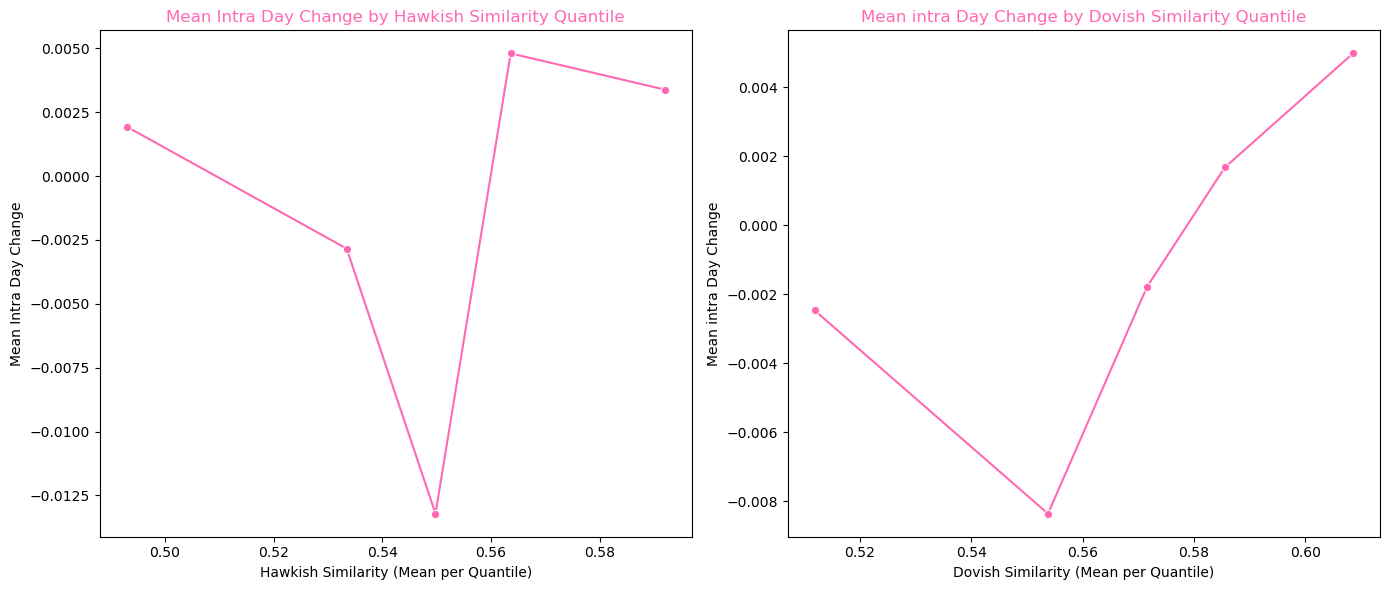

In [158]:
# Replace infinite values with NaN in the 'regress' DataFrame
regress.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define the number of quantiles
n_quantiles = 5

# Create quantile bins for hawkish and dovish similarity
regress['hawkish_quantile'] = pd.qcut(regress['hawkish_similarity'], q=n_quantiles, labels=False)
regress['dovish_quantile'] = pd.qcut(regress['dovish_similarity'], q=n_quantiles, labels=False)

# Group by the quantile and calculate the mean 'next_change' for each quantile
hawkish_grouped = regress.groupby('hawkish_quantile').agg({'Change': 'mean', 'hawkish_similarity': 'mean'})
dovish_grouped = regress.groupby('dovish_quantile').agg({'Change': 'mean', 'dovish_similarity': 'mean'})

# Create the figure for the FacetGrid with custom colors
plt.figure(figsize=(14, 6))

# Plot 1: Hawkish quantile vs mean 'next_change' with a pink theme
plt.subplot(1, 2, 1)
sns.lineplot(x=hawkish_grouped['hawkish_similarity'], y=hawkish_grouped['Change'], color='#FF69B4', marker='o')
plt.title('Mean Intra Day Change by Hawkish Similarity Quantile', color='#FF69B4')
plt.xlabel('Hawkish Similarity (Mean per Quantile)')
plt.ylabel('Mean Intra Day Change')

# Plot 2: Dovish quantile vs mean 'next_change' with a pink theme
plt.subplot(1, 2, 2)
sns.lineplot(x=dovish_grouped['dovish_similarity'], y=dovish_grouped['Change'], color='#FF69B4', marker='o')
plt.title('Mean intra Day Change by Dovish Similarity Quantile', color='#FF69B4')
plt.xlabel('Dovish Similarity (Mean per Quantile)')
plt.ylabel('Mean intra Day Change')

# Style and show the plot
plt.tight_layout()
plt.show()

In [162]:
X = regress[['dovish_similarity', 'hawkish_similarity']]
y = regress['Change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.04753
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.954
Time:                        01:17:19   Log-Likelihood:                 1004.3
No. Observations:                 683   AIC:                            -2003.
Df Residuals:                     680   BIC:                            -1989.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0115      0

Same Happens with Long 

# Conclusion For Factor Similarities